## input data
The header should be self-explanatory. The columns are:
1. logU  - log of the ionization parameter at the Stroemgren radius
2. Z - gas metallicity 
3. xi - dust-to-metal mass ratio
4. lnh - log of hydrogen density of the cloud
5. 5-35. predicted line intensities in erg/s 

In [25]:
# Import required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sbi.inference import SNPE
from sbi.utils import BoxUniform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [26]:
# Load and prepare data
file_path = 'SF_line_info_C100_mup100.dat'

columns = ['logU', 'Z', 'xi', 'lnh', 'NV1240', 'NIV1486', 'CIV1548', 'CIV1551', 'HeII1640', 'OIII1661', 
           'OIII1666', 'NIII1750', 'SiIII1883', 'SiIII1888', 'CIII1909', 'MgII2796', 'MgII2803', 'NeIV2424', 
           'NeV3426', 'OII3727', 'NeIII3869', 'Hdelta', 'Hgamma', 'OIII4363', 'HeII4686', 'Hbeta', 'OIII4959', 
           'OIII5007', 'HeI5876', 'OI6300', 'NII6548', 'Halpha', 'NII6584', 'SII6717', 'SII6731']

data = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=columns)

# Extract parameters and spectra
params = data[['logU', 'Z', 'xi', 'lnh']].values
spectra = data.iloc[:, 4:].values # I call these object "spectra" but they are actually line fluxes

/var/folders/6t/4h_bqrxj52qfg33z_48th4xc0000gn/T/ipykernel_10291/224445576.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=columns)


## Data preparation 
### (splitting train/test, normalisation etc..)

In [27]:
# First split the data
# NB: non splitto in val tanto poi uso il validation_split durante
# la fase di training
# Qui _val e' inteso come _test dunque
params_train, params_val, spectra_train, spectra_val = train_test_split(
    params, 
    spectra,
    test_size=0.05,
    random_state=42,
    shuffle=True
)


In [28]:
# Initialize scalers
param_scaler = StandardScaler() # Standardize parameters
spectra_scaler = StandardScaler() # Standardize spectra 

# Fit scalers only on training data
params_train_normalized = param_scaler.fit_transform(params_train)
spectra_train_normalized = spectra_scaler.fit_transform(spectra_train)

# Transform validation data using the scalers fit on training data
params_val_normalized = param_scaler.transform(params_val)
spectra_val_normalized = spectra_scaler.transform(spectra_val)

# Convert to PyTorch tensors
params_train_tensor = torch.tensor(params_train_normalized, dtype=torch.float32)
params_val_tensor = torch.tensor(params_val_normalized, dtype=torch.float32)
spectra_train_tensor = torch.tensor(spectra_train_normalized, dtype=torch.float32)
spectra_val_tensor = torch.tensor(spectra_val_normalized, dtype=torch.float32)

## start SBI framework

In [31]:
# Define normalized prior (standard normal distribution)
prior = BoxUniform(
    low=torch.tensor([-3.0, -3.0, -3.0, -3.0]),  # Approximately -3 standard deviations
    high=torch.tensor([3.0, 3.0, 3.0, 3.0])      # Approximately +3 standard deviations
)

In [32]:
# Setup neural density estimator 
from sbi.utils.get_nn_models import posterior_nn

density_estimator = posterior_nn(
    model='maf', # Masked Autoregressive Flow (possiamo prova anche con NSF, neuralspline flow)
    hidden_features=128, # Number of hidden units in the neural network
    num_transforms=10, # Number of transformations in the flow
    activation_function="relu",
    dropout_probability=0.1,
    use_batch_norm=False
)



/var/folders/6t/4h_bqrxj52qfg33z_48th4xc0000gn/T/ipykernel_10291/4207294553.py:4: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  density_estimator = posterior_nn(


In [33]:
# Train the model
inference_method = SNPE(prior=prior, density_estimator=density_estimator)

density_estimator = inference_method.append_simulations(
    params_train_tensor, spectra_train_tensor
).train(
    validation_fraction=0.1,
    max_num_epochs=500,
    stop_after_epochs=20, # equivalente of patience in Keras, I guess
    learning_rate=5e-4,
    training_batch_size=64
)

posterior = inference_method.build_posterior(density_estimator)

 Neural network successfully converged after 135 epochs.

## Test on individual objects in the test set
### n_samples is the number of inferences to sample the posteriors

In [35]:
# Single test case inference
def run_single_test(spectra_val_tensor, params_val_tensor, params_val_original, test_idx=None):
    
    if test_idx is None: # If no test index is provided, sample one randomly
        test_idx = np.random.randint(0, len(spectra_val_tensor))

    observed_spectrum = spectra_val_tensor[test_idx]
    true_params_normalized = params_val_tensor[test_idx]
    true_params_original = params_val_original[test_idx]

    if observed_spectrum.dim() == 1:
        observed_spectrum = observed_spectrum.unsqueeze(0)

    # Sample from posterior
    n_samples = 500
    posterior_samples_normalized = posterior.sample((n_samples,), x=observed_spectrum)

    # Convert samples back to original scale
    posterior_samples_orig = param_scaler.inverse_transform(posterior_samples_normalized.numpy())

    # Create DataFrame for visualization
    posterior_df = pd.DataFrame(
        posterior_samples_orig,
        columns=["logU", "Z", "xi", "lnh"]
    )

    # Print results
    print("\nSingle Test Case Results:")
    print("--------------------------")
    for i, param_name in enumerate(["logU", "Z", "xi", "lnh"]):
        print(f"True {param_name}: {true_params_original[i]:.3f}")
        print(f"Posterior mean {param_name}: {posterior_samples_orig.mean(axis=0)[i]:.3f}")
        print(f"Posterior std {param_name}: {posterior_samples_orig.std(axis=0)[i]:.3f}")

    return posterior_df, true_params_original





Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]


Single Test Case Results:
--------------------------
True logU: -3.000
Posterior mean logU: -2.990
Posterior std logU: 0.034
True Z: 0.004
Posterior mean Z: 0.004
Posterior std Z: 0.000
True xi: 0.300
Posterior mean xi: 0.295
Posterior std xi: 0.010
True lnh: 2.000
Posterior mean lnh: 1.603
Posterior std lnh: 0.294


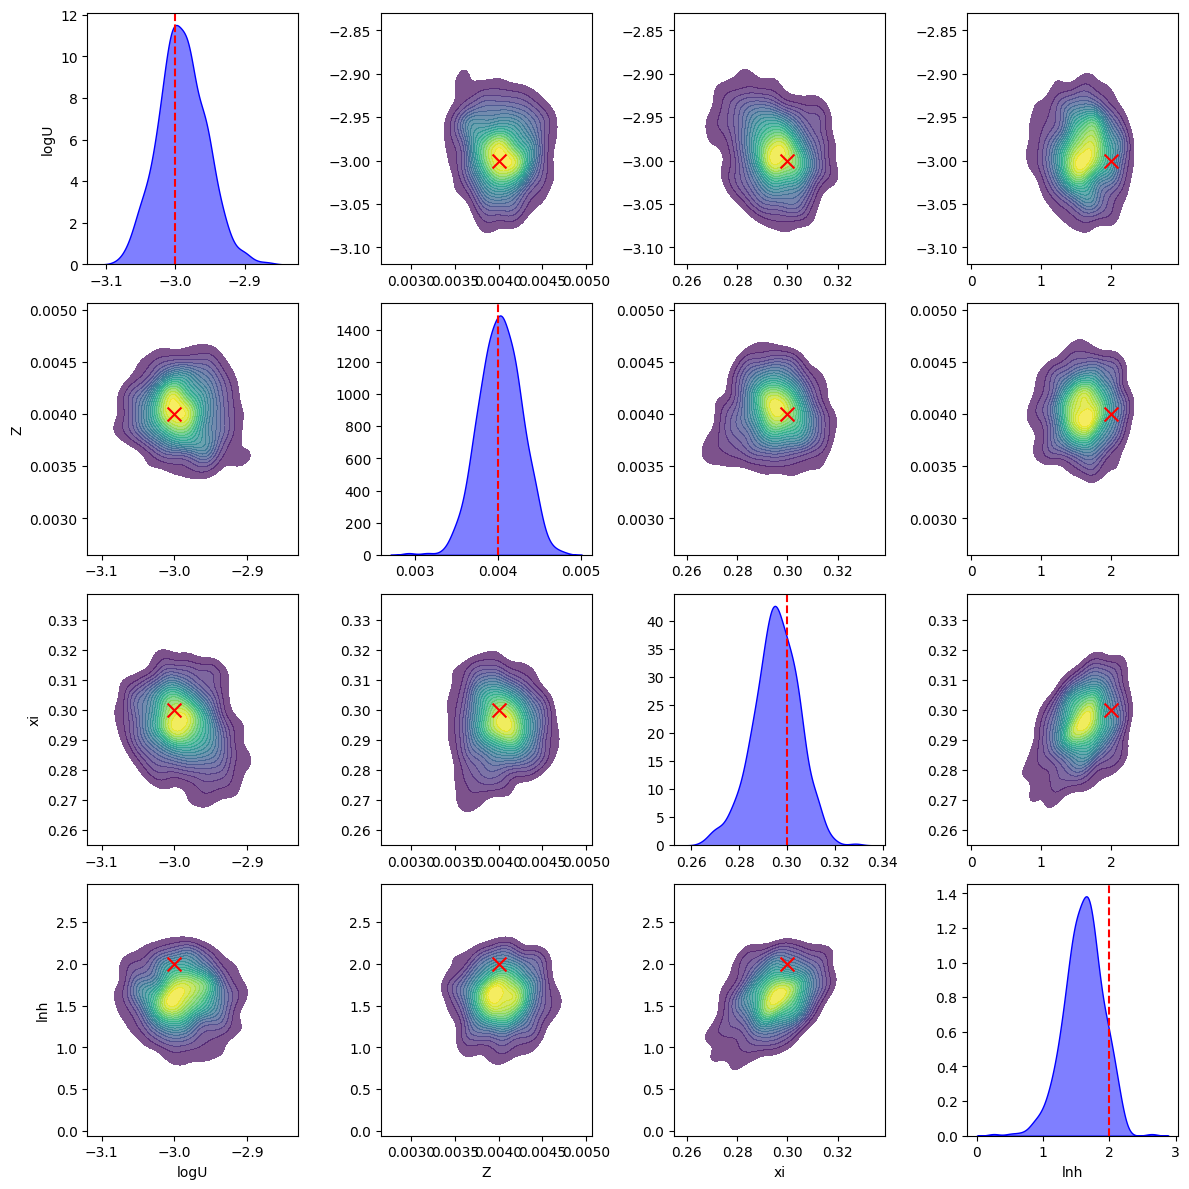

In [20]:
# Example usage:
# Run single test
posterior_df, true_params = run_single_test(spectra_val_tensor, params_val_tensor, params_val)

""""""""""""""""""""""""""""""""""""
"""visualize the posterior distribution"""
""""""""""""""""""""""""""""""""""""

# Create figure and axes grid for the pair plot
param_names = ["logU", "Z", "xi", "lnh"]
n_params = len(param_names)
fig, axes = plt.subplots(n_params, n_params, figsize=(12, 12))

# Create filled KDE plots
for i in range(n_params):
    for j in range(n_params):
        if i != j:  # Off-diagonal plots
            # Create filled KDE plot
            sns.kdeplot(
                data=posterior_df,
                x=param_names[j],
                y=param_names[i],
                ax=axes[i, j],
                fill=True,
                cmap="viridis",
                levels=20,
                alpha=0.7
            )
            
            # Add true values
            axes[i, j].scatter(
                true_params[j], true_params[i],
                color='red', marker='x', s=100, zorder=5
            )
            
        else:  # Diagonal plots
            # Create diagonal KDE plots
            sns.kdeplot(
                data=posterior_df[param_names[i]],
                ax=axes[i, i],
                fill=True,
                color="blue",
                alpha=0.5
            )
            # Add true value line
            axes[i, i].axvline(true_params[i], color='red', linestyle='--')
        
        # Set labels only on the left and bottom edges
        if j == 0:  # leftmost plots
            axes[i, j].set_ylabel(param_names[i])
        else:
            axes[i, j].set_ylabel('')
            
        if i == n_params-1:  # bottom plots
            axes[i, j].set_xlabel(param_names[j])
        else:
            axes[i, j].set_xlabel('')

# Adjust layout
plt.tight_layout()
plt.show()


## test on a number of objects in the test set
### will compare mean of the predicted distribution with labels


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Global Performance on Test Set:
-------------------------------
Mean Absolute Error (logU): 0.040
Mean Absolute Error (Z): 0.000
Mean Absolute Error (xi): 0.013
Mean Absolute Error (lnh): 0.309


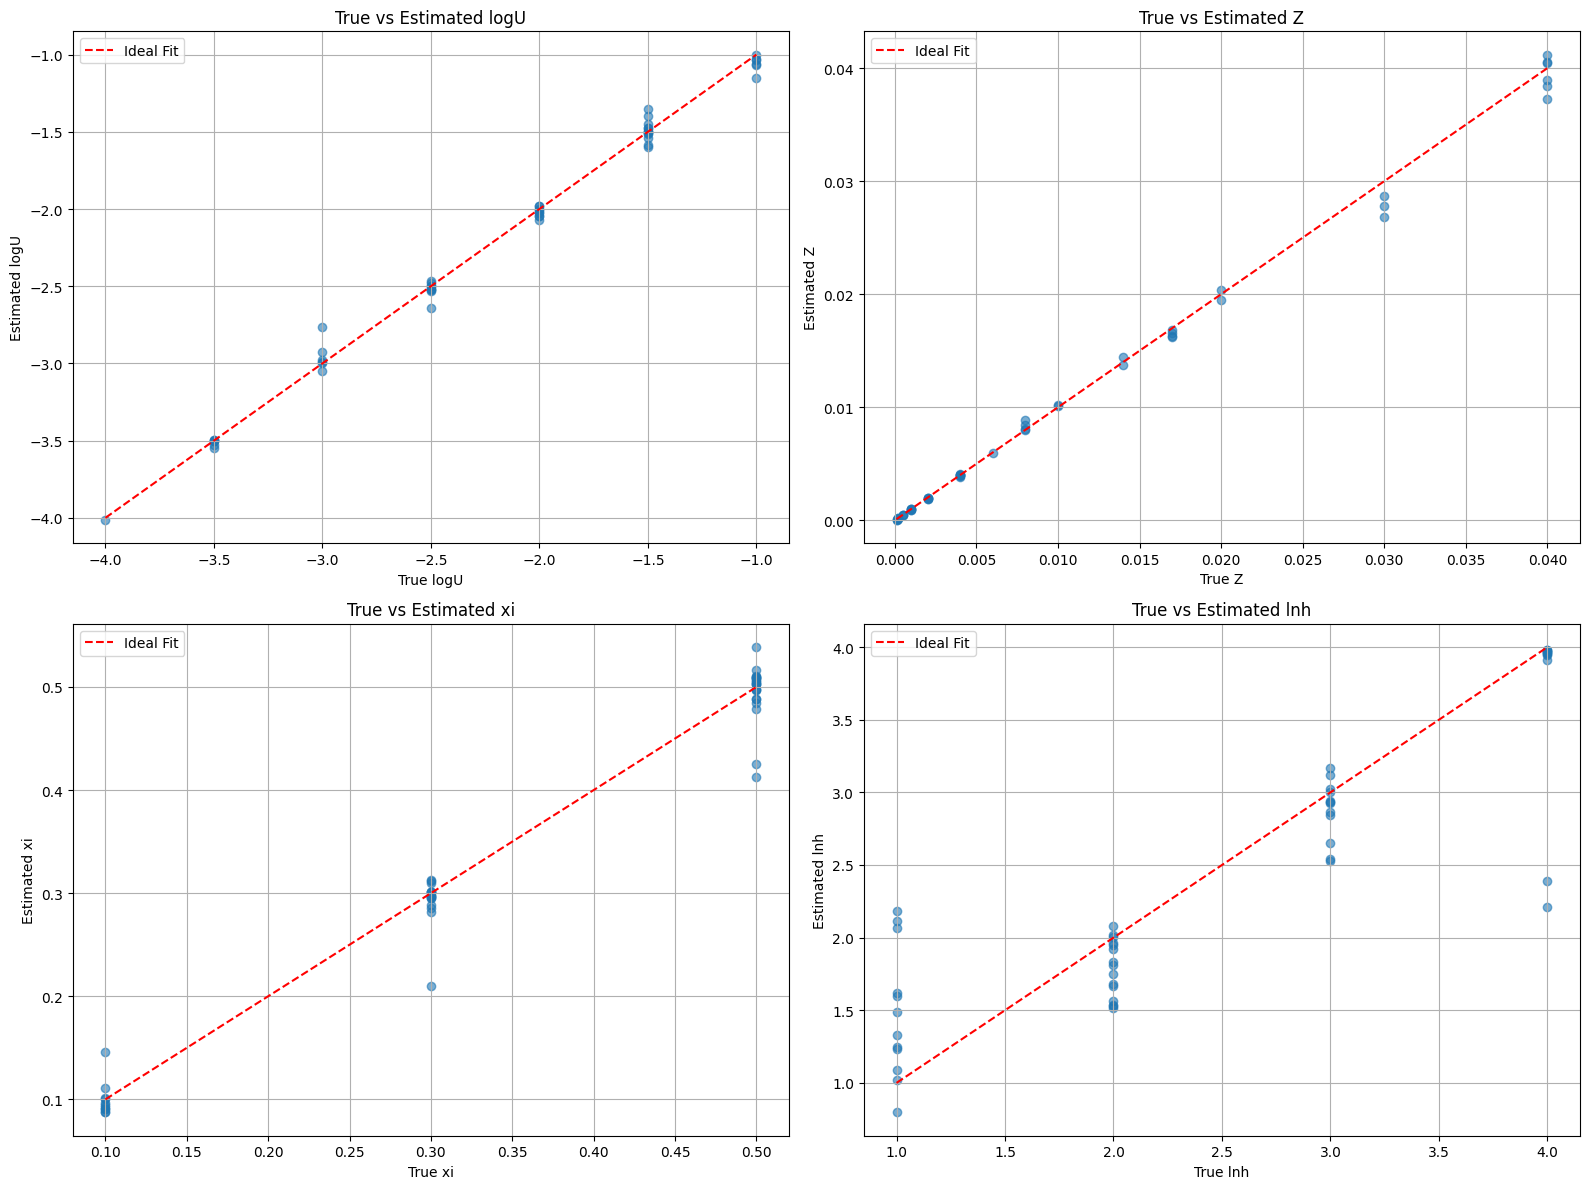

In [36]:
# Global test set evaluation
def evaluate_test_set(n_test_samples=50):
    params_test_normalized = params_val_tensor[:n_test_samples]
    spectra_test = spectra_val_tensor[:n_test_samples]
    params_test_original = params_val[:n_test_samples]

    posterior_means = []
    posterior_stds = []

    for i in range(n_test_samples):
        observed_spectrum = spectra_test[i]
        if observed_spectrum.dim() == 1:
            observed_spectrum = observed_spectrum.unsqueeze(0)

        # Sample from posterior
        posterior_samples_normalized = posterior.sample((1000,), x=observed_spectrum)

        # Convert to original scale before computing statistics
        posterior_samples_orig = param_scaler.inverse_transform(posterior_samples_normalized.numpy())
        posterior_means.append(np.mean(posterior_samples_orig, axis=0))
        posterior_stds.append(np.std(posterior_samples_orig, axis=0))

    posterior_means = np.array(posterior_means)
    posterior_stds = np.array(posterior_stds)

    # Compute MAE in original scale
    mae = np.mean(np.abs(params_test_original - posterior_means), axis=0)

    print("\nGlobal Performance on Test Set:")
    print("-------------------------------")
    for i, param_name in enumerate(["logU", "Z", "xi", "lnh"]):
        print(f"Mean Absolute Error ({param_name}): {mae[i]:.3f}")

    return params_test_original, posterior_means, posterior_stds


# Run global evaluation
true_params, estimated_params, estimated_stds = evaluate_test_set(50)

# Create visualization for global evaluation
param_names = ['logU', 'Z', 'xi', 'lnh']
plt.figure(figsize=(16, 12))

for i, param_name in enumerate(param_names):
    plt.subplot(2, 2, i + 1)
    plt.scatter(true_params[:, i], estimated_params[:, i], alpha=0.6)
    plt.plot([true_params[:, i].min(), true_params[:, i].max()],
             [true_params[:, i].min(), true_params[:, i].max()],
             'r--', label='Ideal Fit')
    plt.xlabel(f'True {param_name}')
    plt.ylabel(f'Estimated {param_name}')
    plt.title(f'True vs Estimated {param_name}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()